<h1 align="center"><font color='gray'>Importing Libraries</font></h1>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN


# Set style
sns.set_style("whitegrid")

<h1 align="center"><font color='gray'>Dataset Overview</font></h1>

In [81]:
df = pd.read_csv("/kaggle/input/customer-behavior-analytcis/customer_behavior_analytcis.csv")
df.set_index("customer_id", inplace=True)

In [121]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,Cluster
customer_id,,,,,,
CM00000,1.125000,1.770508,1.603516,1.372070,0.000000,1
CM00001,1.418945,1.441406,1.200195,1.328125,1.125000,0
CM00002,0.741211,1.504883,1.708008,1.595703,0.741211,2
CM00003,1.449219,1.464844,1.253906,1.343750,1.223633,0
CM00004,1.125000,1.764648,1.517578,1.489258,0.870117,1


In [122]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows in df: {duplicates}")

Number of duplicate rows in df: 0


In [123]:
df.describe().round(2)

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,Cluster
count,999.00,999.00,999.00,999.00,999.00,999.00
mean,1.20,1.61,1.53,1.43,0.73,1.00
std,0.19,0.15,0.17,0.13,0.41,0.82
min,0.00,1.23,1.03,0.96,0.00,0.00
25%,1.08,1.51,1.42,1.34,0.53,0.00
50%,1.22,1.59,1.55,1.41,0.74,1.00
75%,1.36,1.75,1.68,1.57,1.12,2.00
max,1.50,1.84,1.76,1.67,1.29,2.00


In [12]:
def current_stat(df):
    describe = pd.DataFrame(index=df.columns.to_list())
    describe['types'] = df.dtypes
    describe['count'] = df.count()
    describe['nunique'] = df.nunique()
    describe['null'] = df.isnull().sum()
    return describe

In [13]:
current_stat(df)

,types,count,nunique,null
total_purchases,float64,979,32,20
avg_cart_value,float64,979,943,20
total_time_spent,float64,999,953,0
product_click,float64,979,64,20
discount_counts,float64,999,21,0


In [10]:
missing_data = pd.DataFrame({
    'total_missing': df.isnull().sum(), 
    'perc_missing': (df.isnull().sum() / len(df)) * 100  # Convert to percentage
})

missing_data

,total_missing,perc_missing
total_purchases,20,2.002002
avg_cart_value,20,2.002002
total_time_spent,0,0.000000
product_click,20,2.002002
discount_counts,0,0.000000


<h1 align="center"><font color='gray'>Exploratory Data Analysis</font></h1>

In [24]:
def visualize_features(df, col):
    """
    Creates a scatter plot, histogram, and boxplot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Scatter Plot
    axes[0].scatter(df.index, df[col], alpha=0.6, color='blue')
    axes[0].set_title(f"Scatter Plot of {col}")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel(col)
    # axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_xticks([])  # Hide x-axis label

    # Histogram
    sns.histplot(df[col], bins=20, kde=True, ax=axes[1], color='green')
    axes[1].set_title(f"Histogram of {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[2], color='red')
    axes[2].set_title(f"Boxplot of {col}")

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


### Boxplot of numerical variables

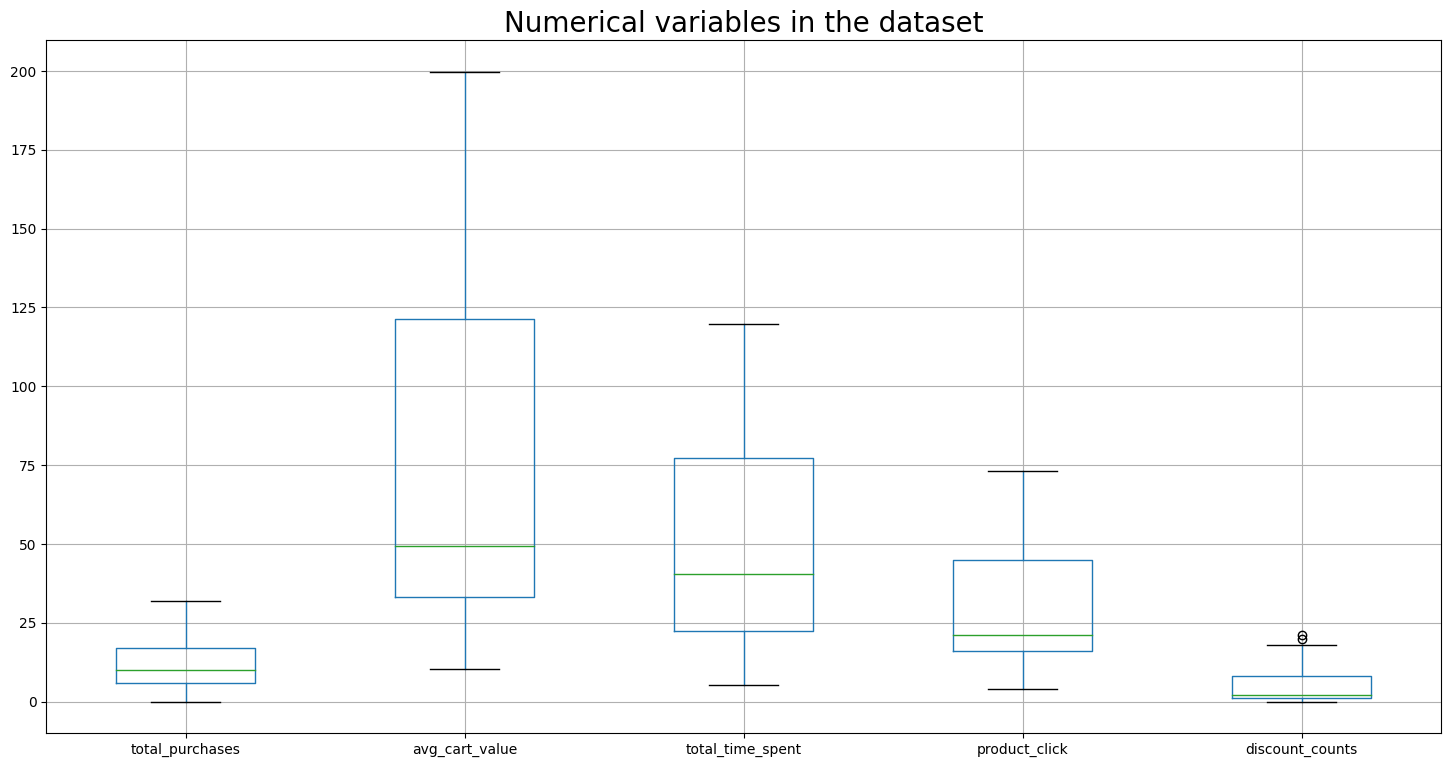

In [16]:
num_cols = ['total_purchases','avg_cart_value','total_time_spent','product_click','discount_counts']
plt.figure(figsize=(18,9))
df[num_cols].boxplot()
plt.title("Numerical variables in the dataset", fontsize=20)
plt.show()

### Handling Outliers

In [17]:
df['discount_counts'].value_counts()

discount_counts
1.0     224
0.0     165
2.0     142
3.0      84
4.0      48
9.0      47
8.0      42
11.0     37
12.0     37
10.0     36
7.0      32
13.0     25
6.0      21
5.0      21
15.0      9
16.0      8
14.0      8
17.0      7
18.0      4
21.0      1
20.0      1
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


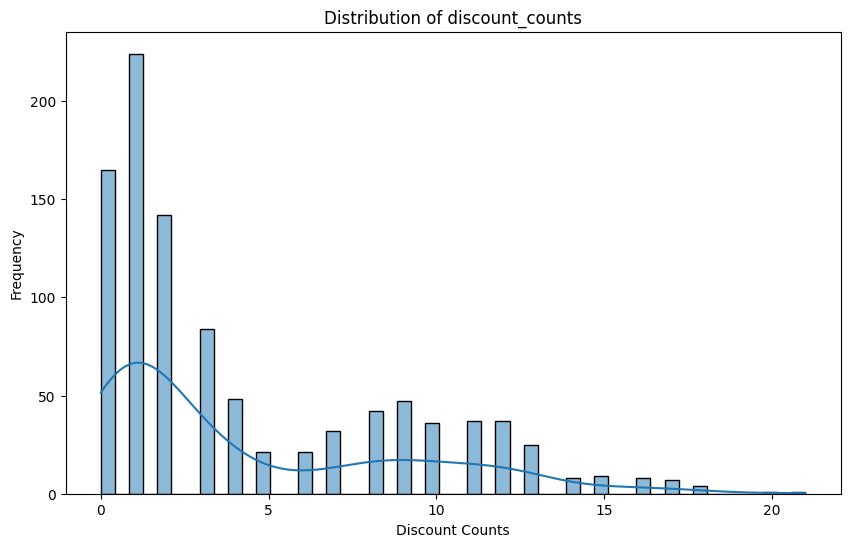

In [18]:
# Plot the distribution of discount_counts
plt.figure(figsize=(10, 6))
sns.histplot(df['discount_counts'], bins=50, kde=True)
plt.title('Distribution of discount_counts')
plt.xlabel('Discount Counts')
plt.ylabel('Frequency')
plt.show()

In [84]:
# Get the value counts
value_counts = df['discount_counts'].value_counts(dropna=False)

# Filter the values with counts below 3
below_3 = value_counts[value_counts < 3]

# Calculate percentage
percentage_below_3 = (below_3.sum() / len(df)) * 100

print(f"Percentage of values with counts below 10: {percentage_below_3:.2f}%")

Percentage of values with counts below 10: 0.20%


In [85]:
value_counts = df['discount_counts'].value_counts(dropna=False)

below_3 = value_counts[value_counts < 20].index

median_all = df['discount_counts'].median()

df['discount_counts'] = df['discount_counts'].apply(lambda x: median_all if x in below_3 else x)

<h1 align="center"><font color='gray'>Data Cleaning & Pre-processing</font></h1>

### Handling Missing Data

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


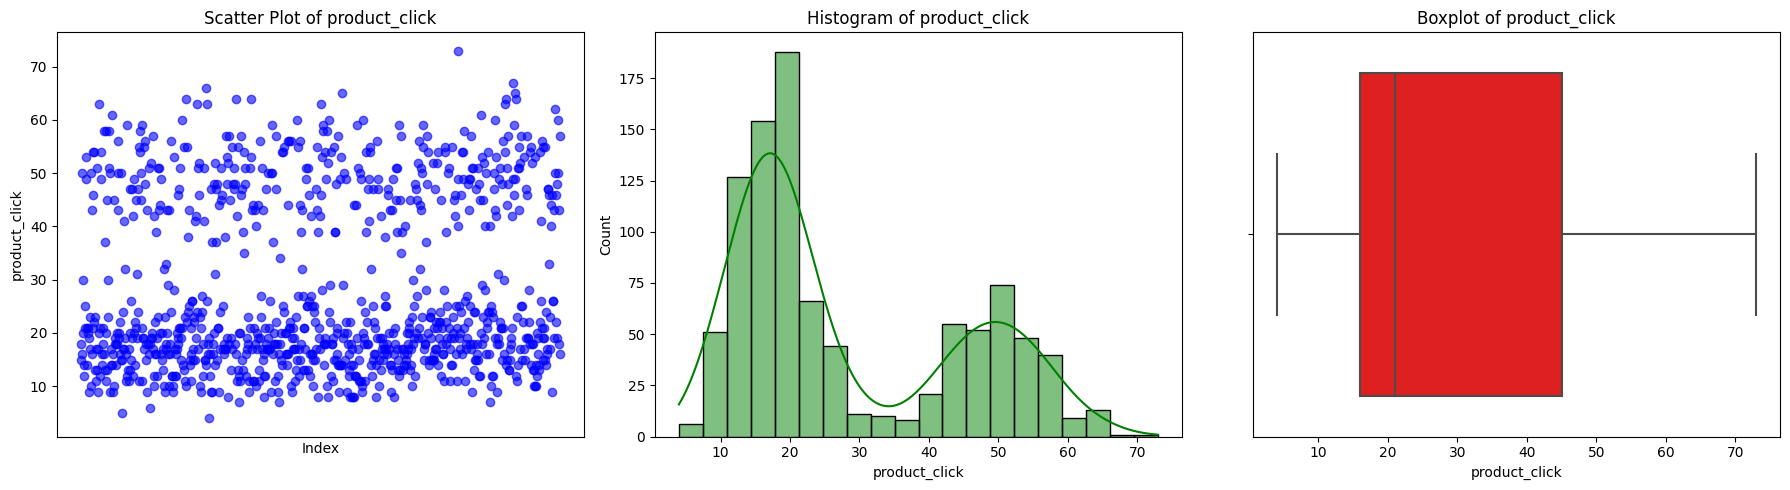

In [25]:
visualize_features(df, 'product_click')

In [87]:
# Check median vs. mean
print(f"Median: {df['product_click'].median()}")
print(f"Mean: {df['product_click'].mean()}")


Median: 21.0
Mean: 28.23799795709908


In [88]:
df['product_click'].fillna(df['product_click'].median(), inplace=True)


<ipython-input-88-b3caecc6cfb7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['product_click'].fillna(df['product_click'].median(), inplace=True)


In [26]:
# # Split data into two groups based on a threshold
# threshold = 30
# group1 = df[df['product_click'] < threshold]
# group2 = df[df['product_click'] >= threshold]

# # Calculate the mode for each group
# mode_group1 = group1['product_click'].mode()[0]
# mode_group2 = group2['product_click'].mode()[0]

# # Fill null values based on the group
# df['product_click'] = df['product_click'].apply(
#     lambda x: mode_group1 if pd.isnull(x) and x < threshold else mode_group2 if pd.isnull(x) else x
# )

# # Verify the changes
# print(df['product_click'].isnull().sum())  # Should be 0

0


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


#### avg_cart_value

In [82]:
df["avg_cart_value"].isnull().sum()

20

In [83]:
# Check median vs. mean
print(f"Median: {df['avg_cart_value'].median()}")
print(f"Mean: {df['avg_cart_value'].mean()}")


Median: 49.38
Mean: 75.4579775280899


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


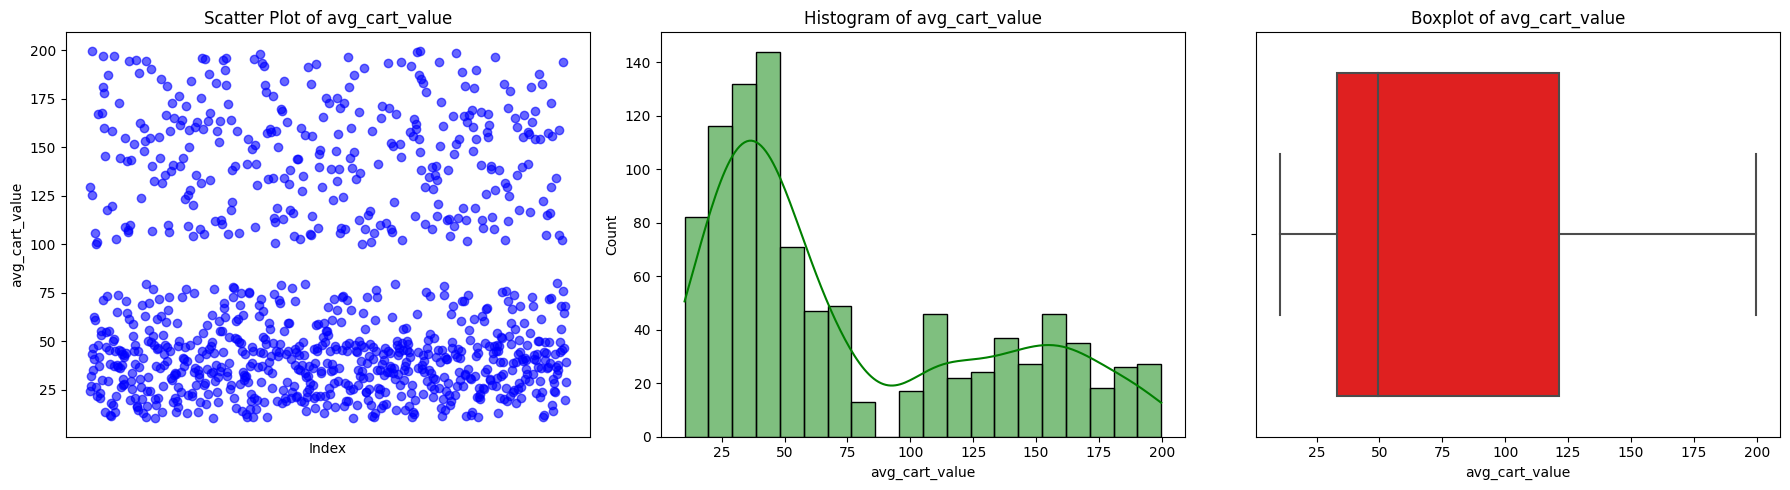

In [29]:
visualize_features(df, "avg_cart_value")

In [32]:
df["avg_cart_value"].describe()

count    979.000000
mean      75.457978
std       55.067835
min       10.260000
25%       33.130000
50%       49.380000
75%      121.255000
max      199.770000
Name: avg_cart_value, dtype: float64

In [90]:
df['product_click'].fillna(df['product_click'].median(), inplace=True)

<ipython-input-90-b3caecc6cfb7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['product_click'].fillna(df['product_click'].median(), inplace=True)


#### total_purchases

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


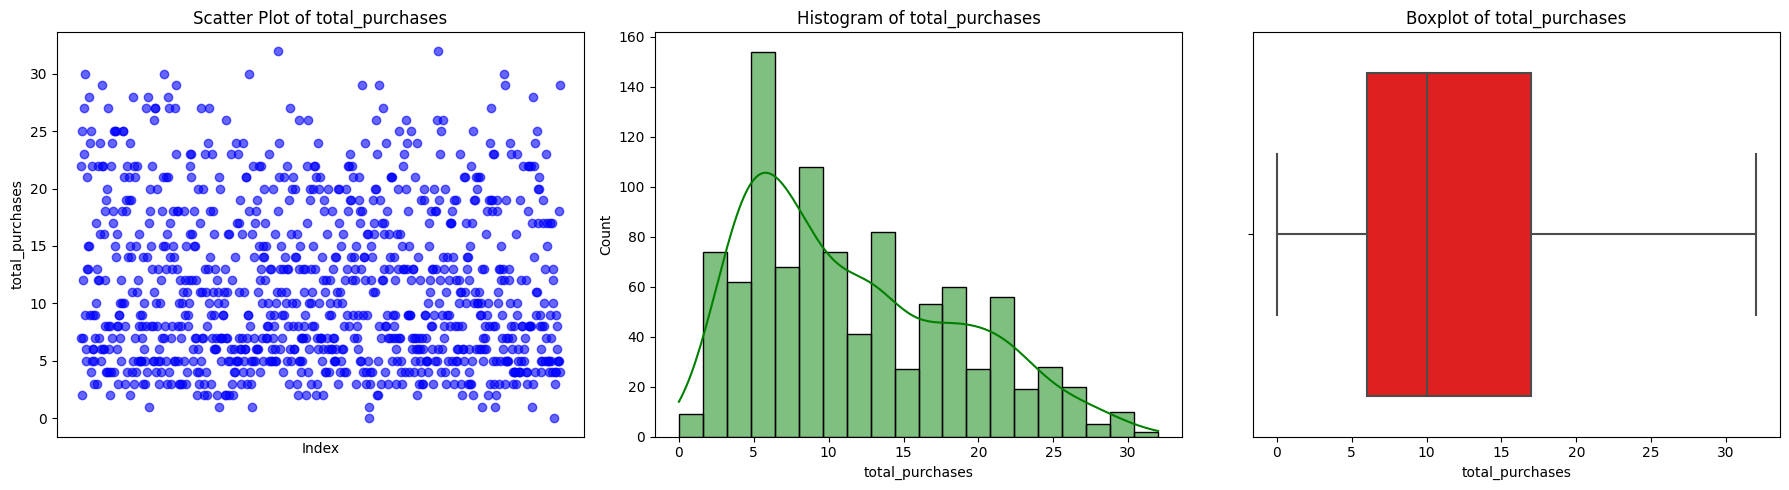

In [34]:
visualize_features(df, "total_purchases")

In [77]:
# Check median vs. mean
print(f"Median: {df['total_purchases'].median()}")
print(f"Mean: {df['total_purchases'].mean()}")


Median: 10.0
Mean: 11.570990806945863


In [35]:
df["total_purchases"].describe()

count    979.000000
mean      11.570991
std        7.016327
min        0.000000
25%        6.000000
50%       10.000000
75%       17.000000
max       32.000000
Name: total_purchases, dtype: float64

In [91]:
df["total_purchases"].fillna(df["total_purchases"].median(), inplace=True)

<ipython-input-91-1599e918cd60>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["total_purchases"].fillna(df["total_purchases"].median(), inplace=True)


In [92]:
df["total_purchases"] = df["total_purchases"].astype(np.int8)
df["product_click"] = df["product_click"].astype(np.int8)
df["discount_counts"] = df["discount_counts"].astype(np.int8)
df["avg_cart_value"] = df["avg_cart_value"].astype(np.float16)  
df["total_time_spent"] = df["total_time_spent"].astype(np.float16)  

# Verify the conversion
df.dtypes

total_purchases        int8
avg_cart_value      float16
total_time_spent    float16
product_click          int8
discount_counts        int8
dtype: object

<h1 align="center"><font color='gray'>Feature Engineering</font></h1>

### EDA via visualizations

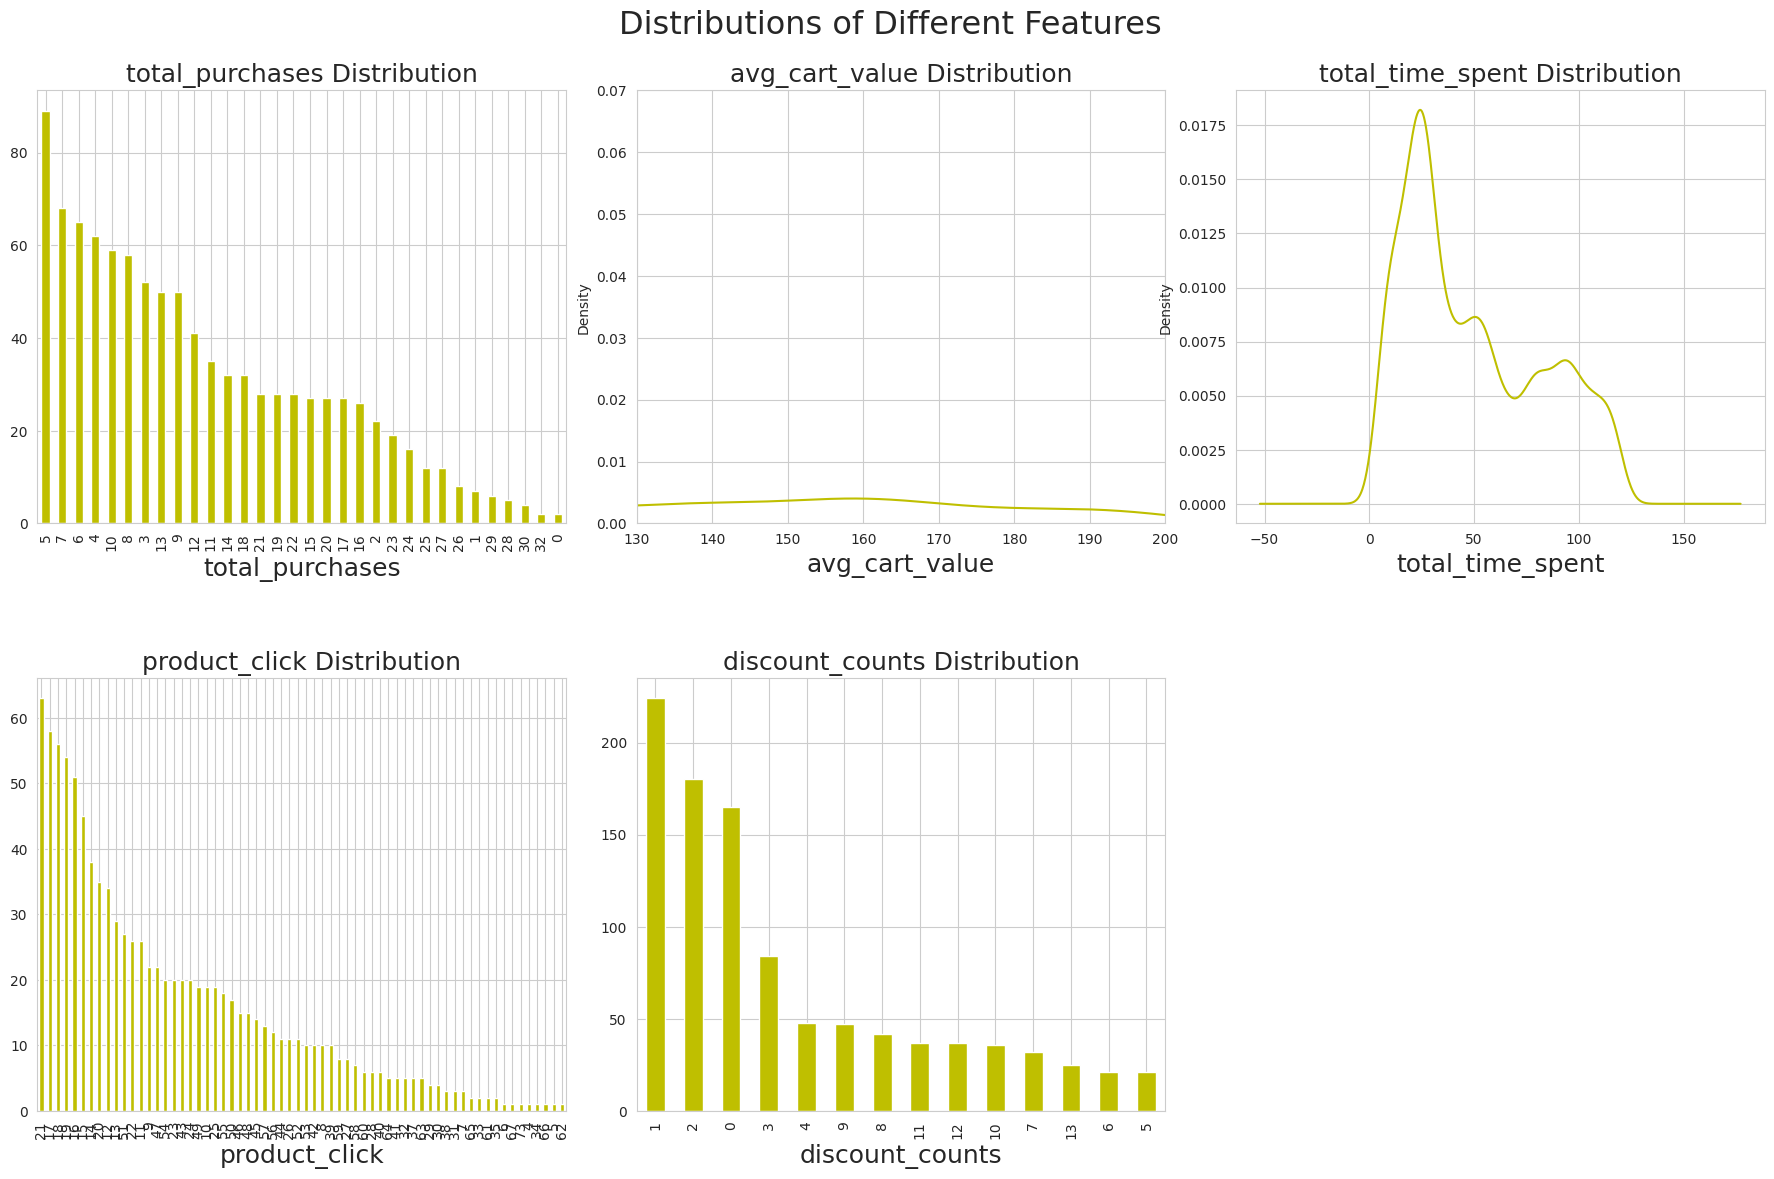

In [93]:
def plot_dist(col, ax):
    if col not in ['avg_cart_value', 'total_time_spent']:  # Fix condition
        df[col].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    else:
        df[col].plot(kind='density', ax=ax, bw_method=0.15, color='y')
        ax.set_xlim(130, 200) if col == 'avg_cart_value' else None  # Adjust limits only for avg_cart_value
        ax.set_ylim(0, 0.07) if col == 'avg_cart_value' else None  
    
    ax.set_xlabel(col, fontsize=18)
    ax.set_title(f"{col} Distribution", fontsize=18)

# Define figure and axes
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for 5 columns
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

# Columns to plot
cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
k = 0

# Iterate over subplots
for i in range(2):
    for j in range(3):
        if k < len(cols):  # Avoid index out of range
            plot_dist(cols[k], ax[i, j])  # Fixed subplot indexing
            k += 1
        else:
            ax[i, j].axis('off')  # Hide extra subplots

# Add title
plt.suptitle("Distributions of Different Features", fontsize=23)

# Show plot
plt.show()


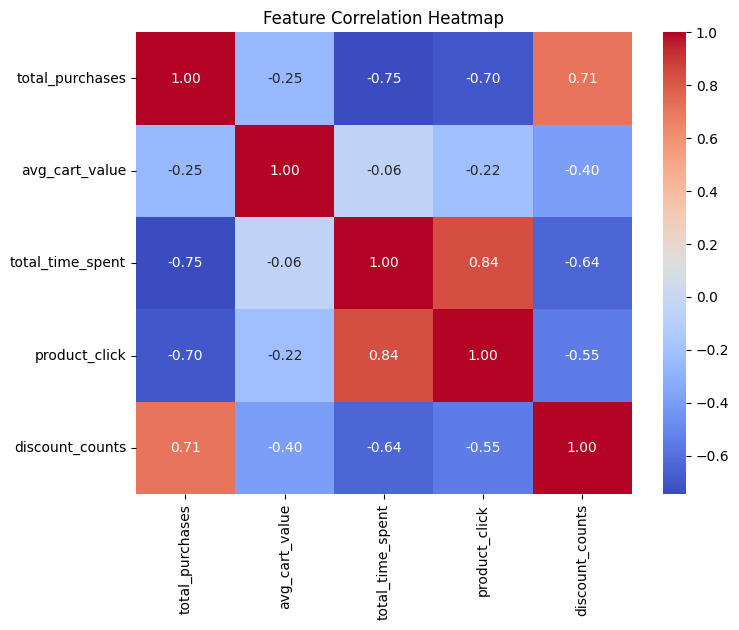

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#### Box-Cox Transformation 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1120: UserWarning: The optimal lambda is 4.623046785785276, but the returned lambda is the constrained optimum to ensure that the maximum or the minimum of the transformed data does not overflow in float16.
  lmax = boxcox_normmax(x, method='mle', optimizer=optimizer)


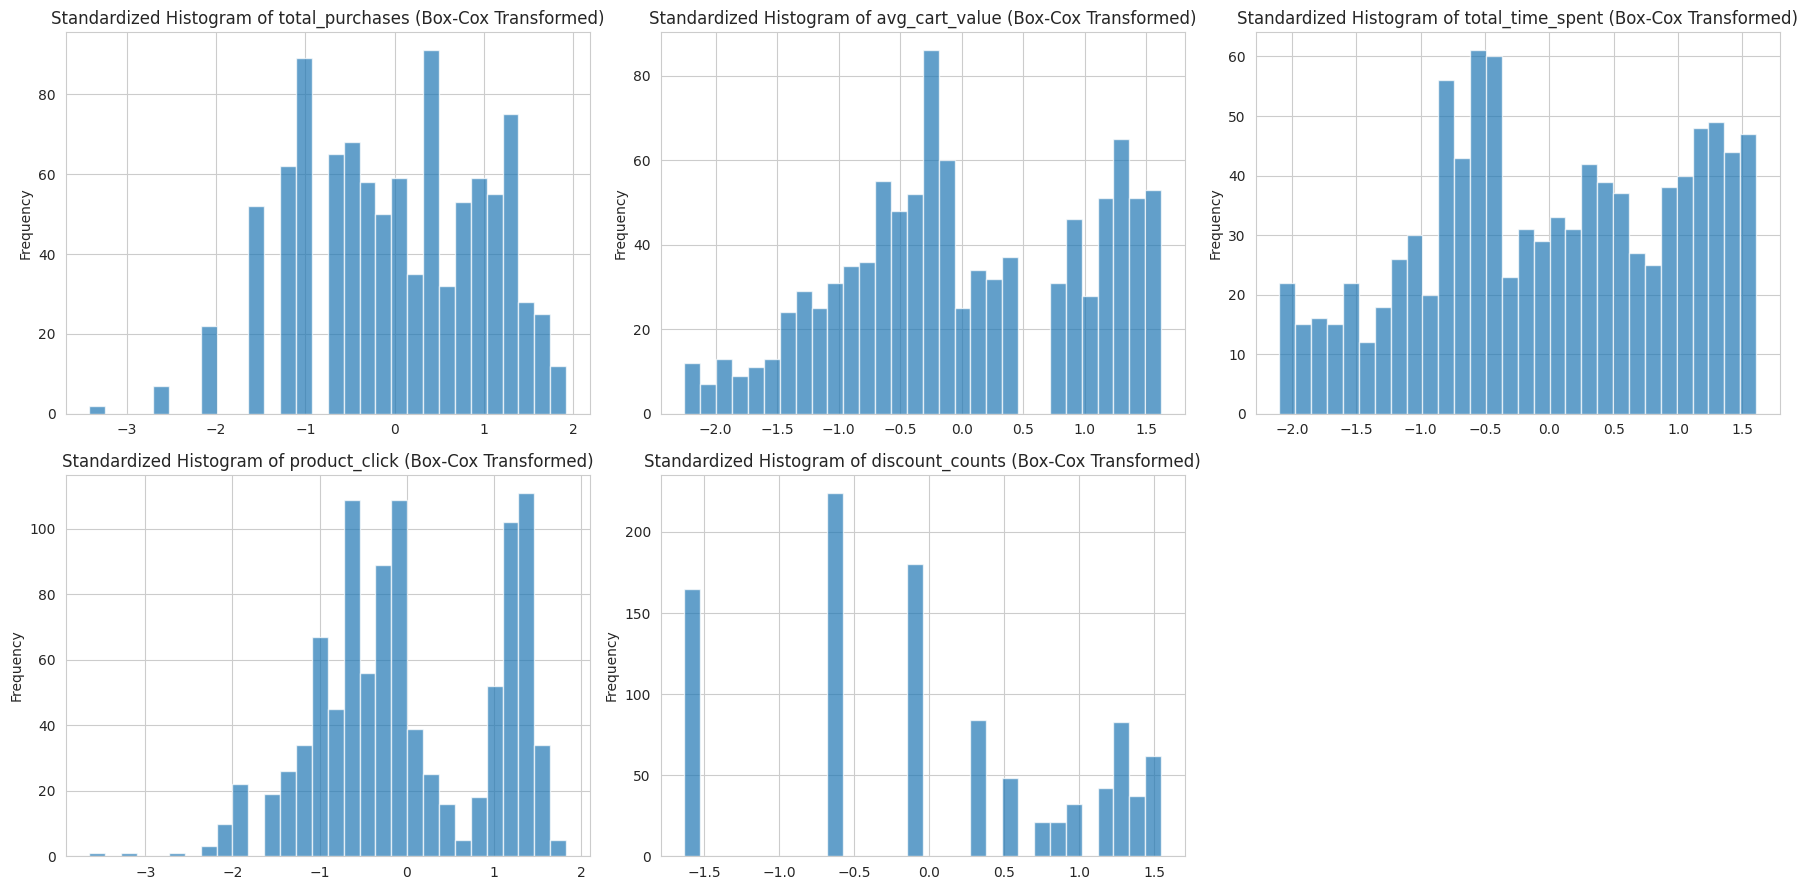

In [104]:
from scipy.stats import boxcox

# Add a small constant to avoid zero or negative values (if any)
df_transformed = df.copy()
for col in num_cols:
    if (df[col] <= 0).any():  # Check if there are non-positive values
        df_transformed[col] = df[col] + 1  # Shift the data to make all values positive

    # Apply Box-Cox transformation
    df_transformed[col], _ = boxcox(df_transformed[col])

# Standardize the Box-Cox transformed data
scaler = StandardScaler()
df_scaled = df_transformed[num_cols].copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# Plot the histograms of the Box-Cox transformed and standardized data
plt.figure(figsize=(18, 9))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  # Arrange plots in a 2x3 grid
    df_scaled[col].plot(kind='hist', bins=30, alpha=0.7)
    plt.title(f'Standardized Histogram of {col} (Box-Cox Transformed)')
    
plt.tight_layout()
plt.show()


#### log transformation

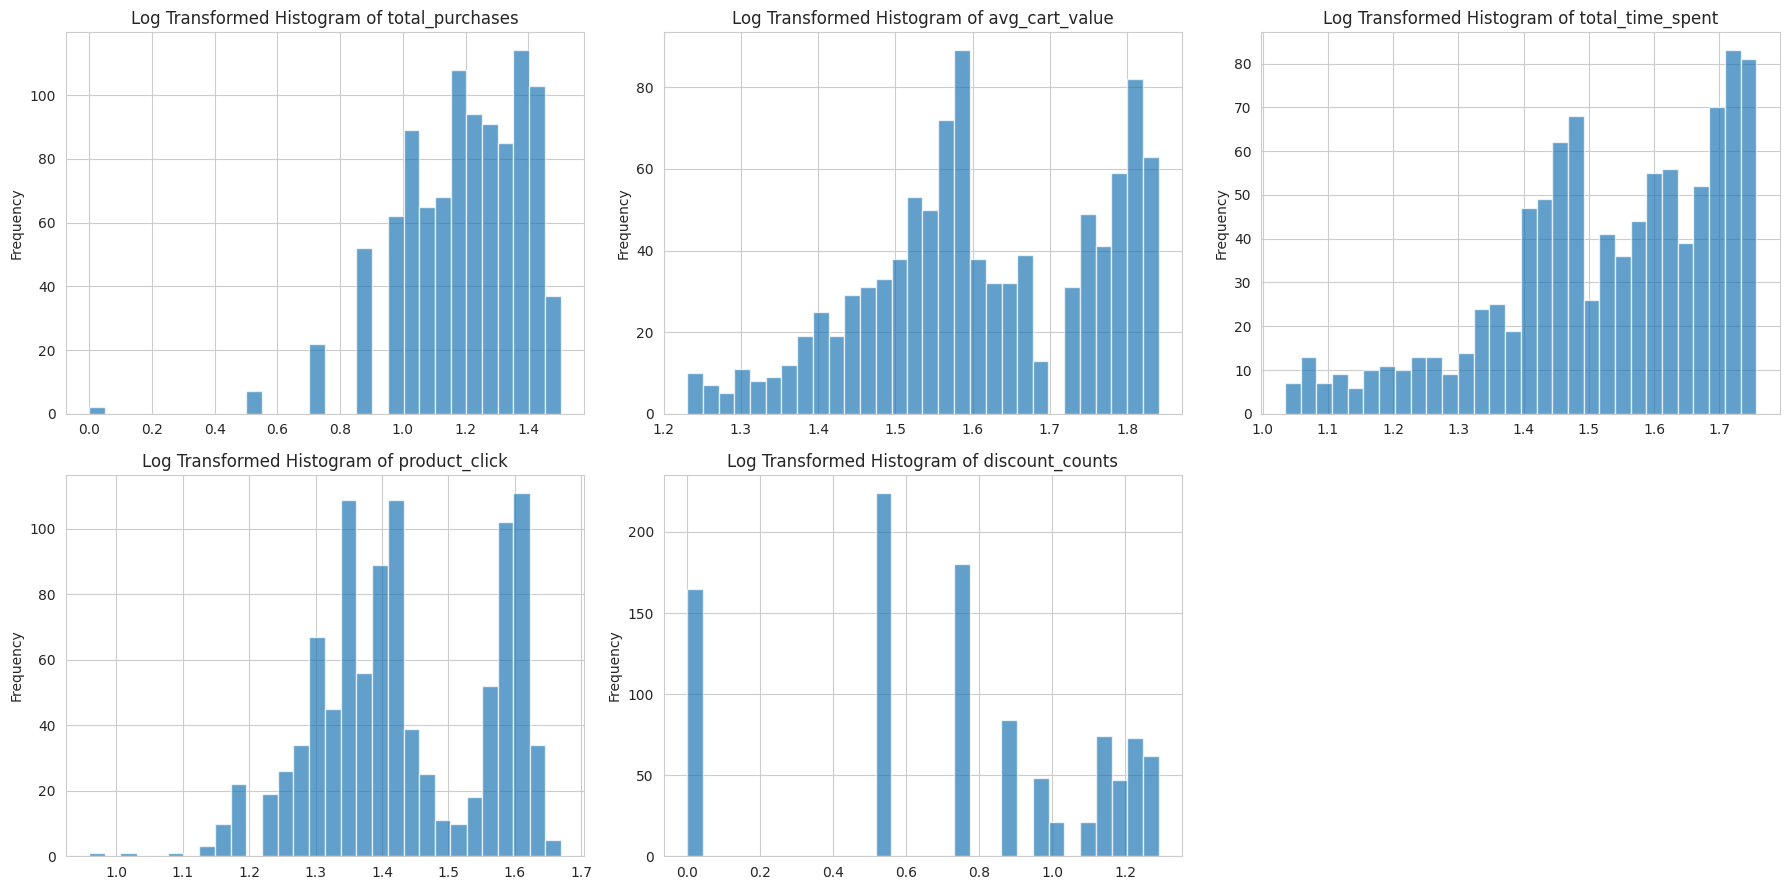

In [97]:
# # Apply log transformation to skewed columns
# skewed_cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
# df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))

### Feature Scaling

In [98]:
# # Standardize the transformed data
# scaler = StandardScaler()
# df_scaled = df[skewed_cols].copy()
# df_scaled[skewed_cols] = scaler.fit_transform(df[skewed_cols])


<h1 align="center"><font color='gray'>Model Selection</font></h1>

### K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5109


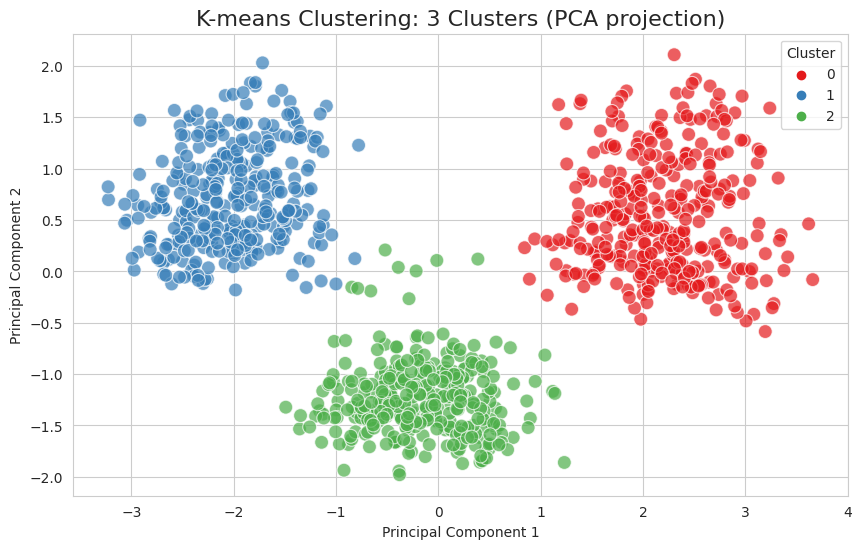

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

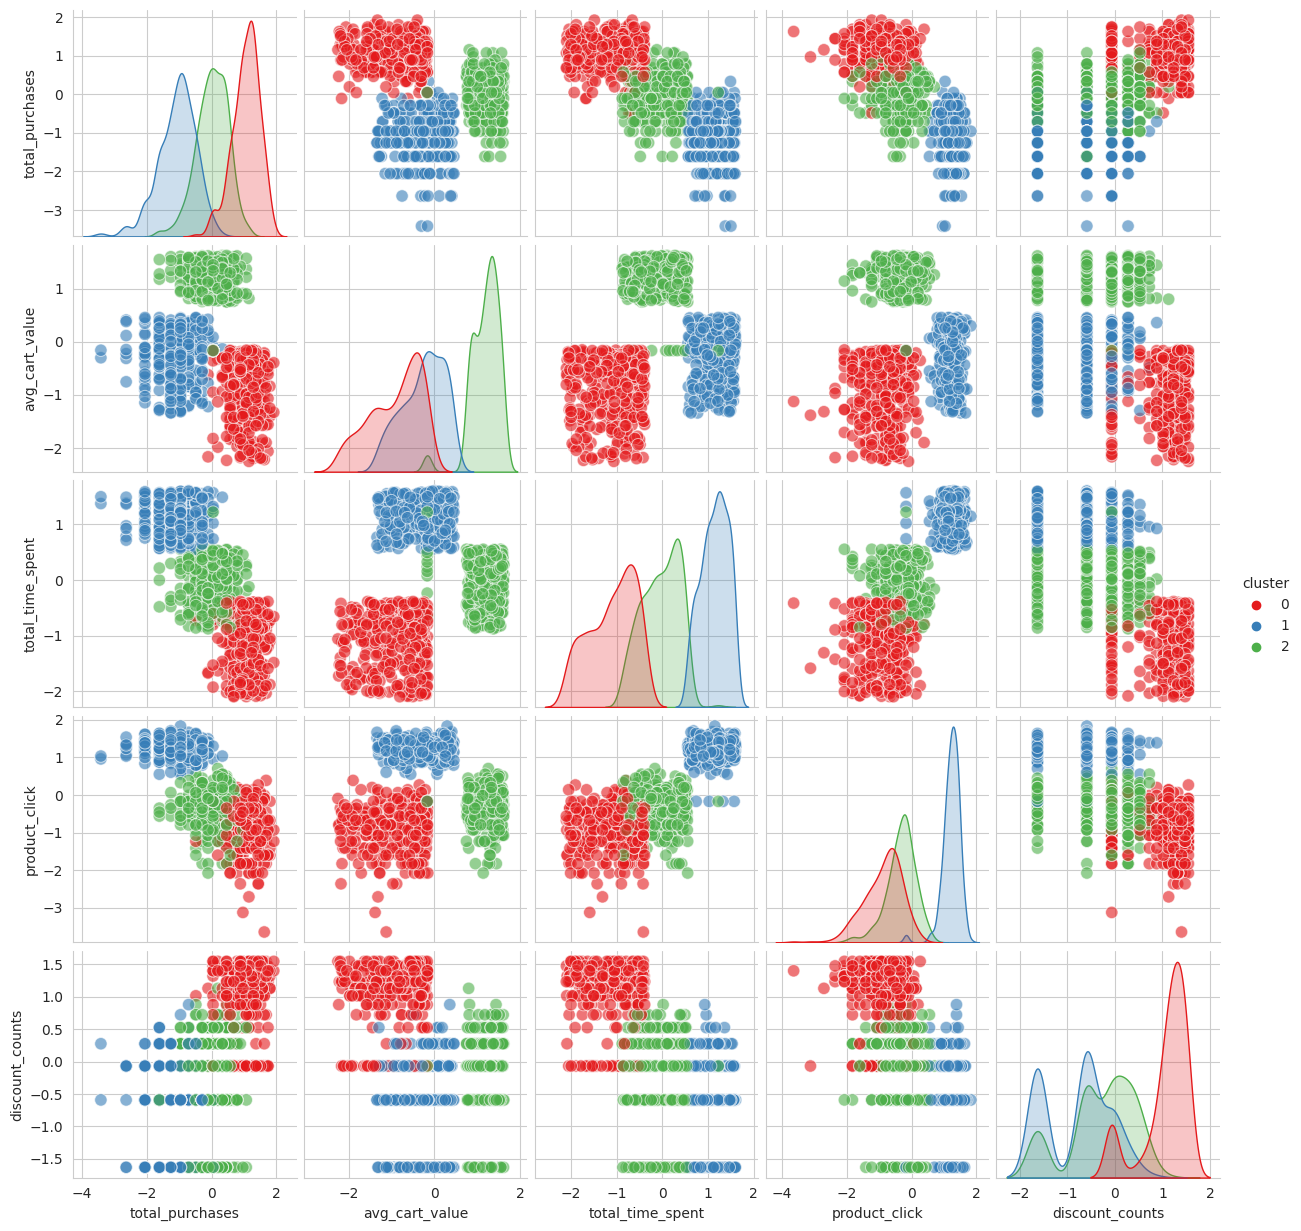

In [106]:
# Set the number of clusters to 3 (based on the problem description)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the standardized and transformed data
kmeans.fit(df_scaled)

# Get the cluster labels for each data point
df_scaled['cluster'] = kmeans.labels_

# Evaluate the clustering using silhouette score
sil_score = silhouette_score(df_scaled[num_cols], kmeans.labels_)
print(f'Silhouette Score: {sil_score:.4f}')

# Plot the clusters in a 2D scatter plot using the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=df_scaled['cluster'], palette="Set1", s=100, alpha=0.7)
plt.title('K-means Clustering: 3 Clusters (PCA projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Optional: Show a pairplot to see the relationships between variables and clusters
sns.pairplot(df_scaled, hue='cluster', palette="Set1", vars=num_cols, plot_kws={'alpha':0.6, 's':80})
plt.show()


In [102]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

Cluster Centers (Means of each cluster):

Cluster Profile (Mean):

Cluster Profile (Median):

Cluster 0 Characteristics:
Total Purchases: Mean: -1.0441333055496216, Median: -0.9586243033409119
Avg Cart Value: Mean: -0.24218426644802094, Median: -0.1680111140012741
Total Time Spent: Mean: 1.1436933279037476, Median: 1.1809396743774414
Product Clicks: Mean: 1.2271288633346558, Median: 1.2343876361846924
Discount Count: Mean: -1.6296207904815674, Median: -1.629620909690857

Cluster 1 Characteristics:
Total Purchases: Mean: 1.1250935792922974, Median: 1.152098298072815
Avg Cart Value: Mean: -0.7241178750991821, Median: -0.6646363735198975
Total Time Spent: Mean: -1.3965623378753662, Median: -1.4633954763412476
Product Clicks: Mean: -1.7045613527297974, Median: -1.600829005241394
Discount Count: Mean: 1.2291220426559448, Median: 1.32139253616333

Cluster 2 Characteristics:
Total Purchases: Mean: -0.14490073919296265, Median: -0.10946831852197647
Avg Cart Value: Mean: 1.1977019309997559, Med

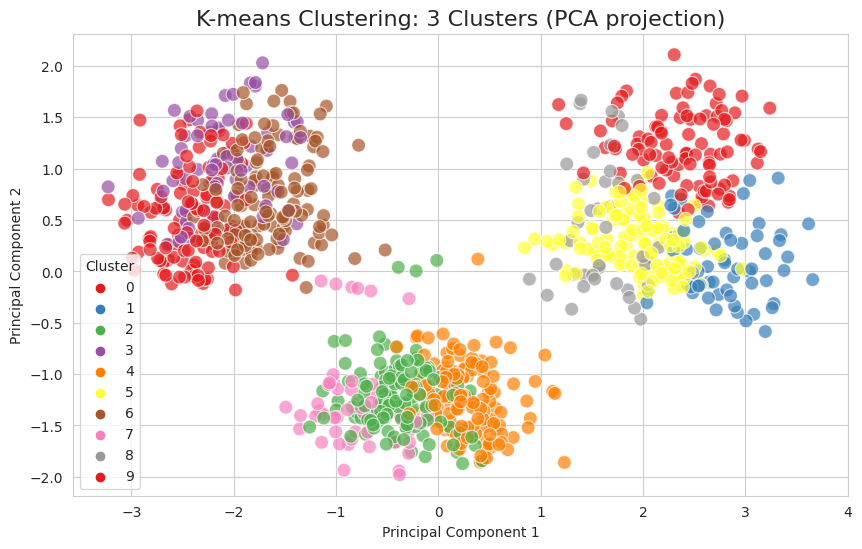

In [119]:
# Step 1: Get the cluster centers (means of each cluster)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=num_cols)
print("Cluster Centers (Means of each cluster):")
cluster_centers

# Step 2: Calculate the mean and median for each feature in each cluster
cluster_profile_mean = df_scaled.groupby('cluster')[num_cols].mean()
cluster_profile_median = df_scaled.groupby('cluster')[num_cols].median()

# Display the cluster profiles
print("\nCluster Profile (Mean):")
cluster_profile_mean

print("\nCluster Profile (Median):")
cluster_profile_median

# Step 3: Manually check if clusters align with the expected segment behavior
# Check the characteristics for each cluster
for cluster in range(3):  # Assuming 3 clusters
    print(f"\nCluster {cluster} Characteristics:")
    print(f"Total Purchases: Mean: {cluster_profile_mean.iloc[cluster]['total_purchases']}, Median: {cluster_profile_median.iloc[cluster]['total_purchases']}")
    print(f"Avg Cart Value: Mean: {cluster_profile_mean.iloc[cluster]['avg_cart_value']}, Median: {cluster_profile_median.iloc[cluster]['avg_cart_value']}")
    print(f"Total Time Spent: Mean: {cluster_profile_mean.iloc[cluster]['total_time_spent']}, Median: {cluster_profile_median.iloc[cluster]['total_time_spent']}")
    print(f"Product Clicks: Mean: {cluster_profile_mean.iloc[cluster]['product_click']}, Median: {cluster_profile_median.iloc[cluster]['product_click']}")
    print(f"Discount Count: Mean: {cluster_profile_mean.iloc[cluster]['discount_counts']}, Median: {cluster_profile_median.iloc[cluster]['discount_counts']}")
    
# Optional: Visualize clusters to further analyze separations
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=df_scaled['cluster'], palette="Set1", s=100, alpha=0.7)
plt.title('K-means Clustering: 3 Clusters (PCA projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


Cluster Centers (Means of each cluster):
   total_purchases  avg_cart_value  total_time_spent  product_click  \
0        -1.044133       -0.242184          1.143693       1.227129   
1         1.125093       -0.724118         -1.396562      -1.704561   
2        -0.144901        1.197702          0.049433      -0.255281   
3        -1.699821       -0.392805          1.174757       1.261973   
4         0.157075        1.217926         -0.130651      -0.444637   
5         0.989618       -0.494320         -0.963667      -0.601649   
6        -0.740023       -0.211379          1.123854       1.203226   
7         0.059189        0.996088         -0.024923      -0.237864   
8         1.077032       -0.968435         -1.047317      -0.812578   
9         1.097734       -1.604189         -1.131973      -0.815821   

   discount_counts  
0        -1.629621  
1         1.229122  
2        -0.381523  
3        -0.239571  
4         0.297086  
5         1.239364  
6        -0.379321  
7        

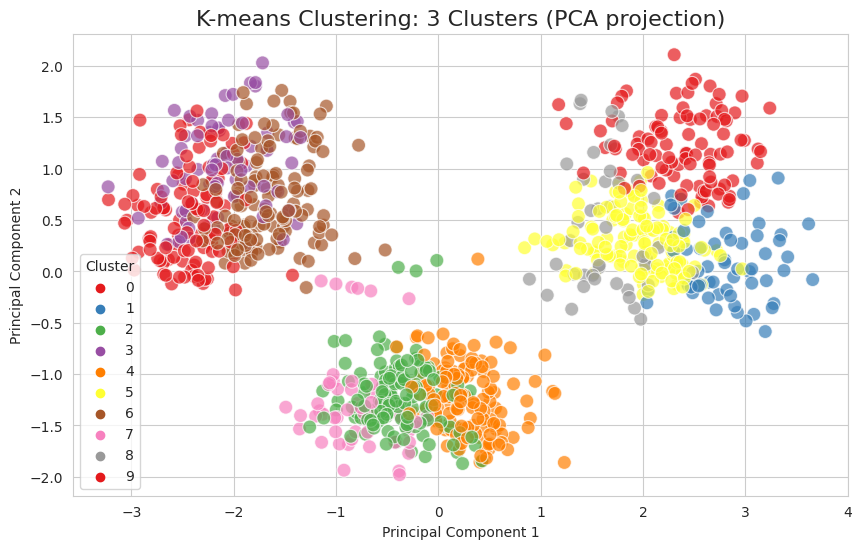

In [120]:
# Step 1: Get the cluster centers (means of each cluster)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=num_cols)
print("Cluster Centers (Means of each cluster):")
print(cluster_centers)

# Step 2: Calculate the mean and median for each feature in each cluster
cluster_profile_mean = df_scaled.groupby('cluster')[num_cols].mean()
cluster_profile_median = df_scaled.groupby('cluster')[num_cols].median()

# Step 3: Define the criteria for each segment (based on the expected behavior)
def assign_segment(cluster_profile):
    if (cluster_profile['total_purchases'] > 10 and 
        cluster_profile['avg_cart_value'] < 50 and
        cluster_profile['total_time_spent'] < 60 and
        cluster_profile['product_click'] < 30 and
        cluster_profile['discount_counts'] > 5):
        return 'Bargain Hunters'  # Deal-seekers
    elif (cluster_profile['total_purchases'] > 5 and 
          cluster_profile['avg_cart_value'] > 100 and 
          cluster_profile['total_time_spent'] < 60 and
          cluster_profile['discount_counts'] < 2):
        return 'High Spenders'  # Premium buyers
    elif (cluster_profile['total_purchases'] < 5 and 
          cluster_profile['avg_cart_value'] > 50 and
          cluster_profile['total_time_spent'] > 60 and
          cluster_profile['product_click'] > 30 and 
          cluster_profile['discount_counts'] < 3):
        return 'Window Shoppers'  # Spend time browsing without buying

    return 'Uncategorized'  # In case none of the conditions match

# Step 4: Apply the function to each cluster's profile
cluster_labels = cluster_profile_mean.apply(assign_segment, axis=1)

# Print out the labels for each cluster
print("\nAssigned Segment Labels for Each Cluster:")
print(cluster_labels)

# Step 5: Visualize the clusters with PCA (optional, for verification)
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=df_scaled['cluster'], palette="Set1", s=100, alpha=0.7)
plt.title('K-means Clustering: 3 Clusters (PCA projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


<h1 align="center"><font color='gray'>Model Evaluation</font></h1>

### Silhouette Score

In [103]:
score = silhouette_score(scaled_data, df["Cluster"])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.583


In [111]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts'])
centroids

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
0,1.056140,-0.918128,-1.099943,-0.88605,1.067690
1,-1.069552,-0.264904,1.140970,1.22120,-0.780095
2,0.010170,1.178697,-0.037488,-0.33049,-0.289069


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

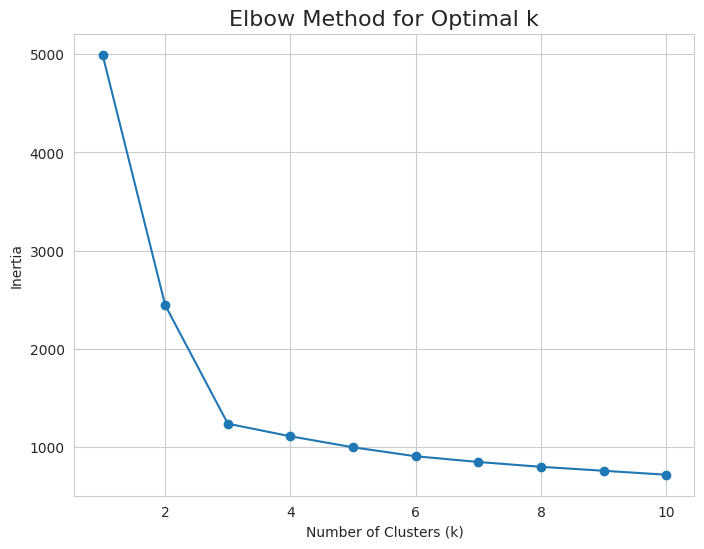

In [112]:
# Inertia calculation for different values of k (from 1 to 10)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[num_cols])
    inertia.append(kmeans.inertia_)

# Plot the inertia to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k", fontsize=16)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


In [109]:
df.groupby("Cluster").mean()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
Cluster,,,,,
0,1.382358,1.471249,1.333477,1.316424,1.136082
1,1.212234,1.781608,1.543288,1.388675,0.626391
2,0.987661,1.576850,1.703427,1.591181,0.413706



* Cluster 0 → Bargain Hunters
* Cluster 1 → High Spenders
* Cluster 2 → Window Shoppers
